<a href="https://colab.research.google.com/github/arjunjyothieswarb/CS5180/blob/main/Project/RL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# from four_room_env import *
from plot_util import *

## Environments

### FourRooms

In [2]:
import matplotlib.pyplot as plt
import numpy as np
""" Here is the implementation of the FourRooms
    Note that, the reward function is changed to be:
        - If the agent reaches the goal, it receives 0 and the episode terminates.
        - For other time step, the agent receives -1 reward.
"""
class FourRooms(object):
    def __init__(self):
        # We define the grid for the Four Rooms domain
        self.grid = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


        # self.grid = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        #                       [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
        #                       [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        #                       [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        #                       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        #                       [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1],
        #                       [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        #                       [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        #                       [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        #                       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        #                       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


        # We define the observation space consisting of all empty cells
        # Note: We have to flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        self.observation_space = np.argwhere(self.grid >= 0.0).tolist()  # Fine all empty cells
        self.observation_space = self.arr_coords_to_four_room_coords(self.observation_space)

        # We define the action space
        self.action_space = {'up': np.array([0, 1]),
                             'down': np.array([0, -1]),
                             'left': np.array([-1, 0]),
                             'right': np.array([1, 0])}
        self.action_names = ['up', 'down', 'left', 'right']

        # We define the start location
        self.start_location = [0, 0]
        # self.start_location = [1, 1]

        # We define the goal location
        self.goal_location = [10, 10]
        # self.goal_location = [9, 9]

        # We find all wall cells
        self.walls = np.argwhere(self.grid == 1.0).tolist()  # find all wall cells
        self.walls = self.arr_coords_to_four_room_coords(self.walls)  # convert to Four Rooms coordinates

        # This is an episodic task, we define a timeout: maximal time steps = 459
        self.max_time_steps = 459

        # We define other useful variables
        self.agent_location = None  # track the agent's location in one episode.
        self.action = None  # track the agent's action
        self.t = 0  # track the current time step in one episode

    @staticmethod
    def arr_coords_to_four_room_coords(arr_coords_list):
        """
        Function converts the array coordinates to the Four Rooms coordinates (i.e, The origin locates at bottom left).
        E.g., The coordinates (0, 0) in the numpy array is mapped to (0, 10) in the Four Rooms coordinates.
        Args:
            arr_coords_list (list): a list variable consists of tuples of locations in the numpy array

        Return:
            four_room_coords_list (list): a list variable consists of tuples of converted locations in the
                                          Four Rooms environment.
        """
        # Note: We have to flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        four_room_coords_list = [(column_idx, 10 - row_idx) for (row_idx, column_idx) in arr_coords_list]
        return four_room_coords_list

    def reset(self):
        # We reset the agent's location to the start location
        self.agent_location = self.start_location

        # We reset the timeout tracker to be 0
        self.t = 0

        # We set the information
        info = {}
        return self.agent_location, info

    def step(self, action):
        """
        Args:
            action (string): a string variable (i.e., "UP"). All feasible values are ["up", "down", "left", "right"].
        """
        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if action == "left" or action == "right":
                action = np.random.choice(["up", "down"], 1)[0]
            else:
                action = np.random.choice(["right", "left"], 1)[0]

        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the action name to movement array
        act_arr = self.action_space[action]

        # Compute the agent's next location
        next_agent_location = np.clip(loc_arr + act_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([10, 10])).tolist()

        # Check if the agent crashes into walls, it stays at the current location.
        if tuple(next_agent_location) in self.walls:
            next_agent_location = self.agent_location

        """Note that, the reward function is changed as follows.
        """
        # Compute the reward
        reward = 0.0 if next_agent_location == self.goal_location else -1.0

        # Check the termination
        # If the agent reaches the goal, reward = 0, done = True
        # If the time steps reaches the maximal number, reward = -1, done = True.
        if reward == 0.0 or self.t == self.max_time_steps:
            terminated = True
        else:
            terminated = False

        # Update the agent's location, action and time step trackers
        self.agent_location = next_agent_location
        self.action = action
        self.t += 1

        return next_agent_location, reward, terminated, False, {}

    def render(self):
        # plot the agent and the goal
        # empty cell = 0
        # wall cell = 1
        # agent cell = 2
        # goal cell = 3
        plot_arr = self.grid.copy()
        plot_arr[10 - self.agent_location[1], self.agent_location[0]] = 2
        plot_arr[10 - self.goal_location[1], self.goal_location[0]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.1)

    @staticmethod
    def test():
        my_env = FourRooms()
        state, _ = my_env.reset()

        for _ in range(100):
            action = np.random.choice(list(my_env.action_space.keys()), 1)[0]

            next_state, reward, done, _, _ = my_env.step(action)
            my_env.render()

            if done:
                state, _ = my_env.reset()
            else:
                state = next_state

### WindyGridWorld

In [3]:

# @title WindyGridWorld
class WindyGridWorld(object):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        # define the grid space
        self.grid = np.zeros((7, 10))

        # define the state space
        self.state_space = [[r, c] for r, c in zip(np.where(self.grid == 0.0)[0],
                                                   np.where(self.grid == 0.0)[1])]
        self.observation_space = self.state_space

        # define the start state
        self.start_state = [3, 0]

        # define the goal state
        self.goal_state = [3, 7]

        # define the wind
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0], dtype=int)

        # define the action space


        # Enable King's moves (Comment out the above action space to create a new one for King's moves)
        if enable_king_move:

            if enable_no_move:
                #TODO
                self.action_space = {
                                "up": np.array([-1, 0]),
                                "down": np.array([1, 0]),
                                "left": np.array([0, -1]),
                                "right": np.array([0, 1]),
                                "up-left": np.array([-1, -1]),
                                "up-right": np.array([-1, 1]),
                                "down-left": np.array([1, -1]),
                                "down-right": np.array([1, 1]),
                                "freeze": np.array([0, 0])
                            }
            else:
                #TODO
                self.action_space = {
                                "up": np.array([-1, 0]),
                                "down": np.array([1, 0]),
                                "left": np.array([0, -1]),
                                "right": np.array([0, 1]),
                                "up-left": np.array([-1, -1]),
                                "up-right": np.array([-1, 1]),
                                "down-left": np.array([1, -1]),
                                "down-right": np.array([1, 1])
                            }

        else:
            #TODO
            self.action_space = {
                                "up": np.array([-1, 0]),
                                "down": np.array([1, 0]),
                                "left": np.array([0, -1]),
                                "right": np.array([0, 1])
                            }


        # track the current state, time step, and action
        self.state = None
        self.t = None
        self.act = None


    def reset(self):
        # reset the agent to the start state
        self.state = self.start_state[:]
        # reset the time step tracker
        self.t = 0
        # reset the action tracker
        self.act = None
        # reset the terminal flag
        terminated = False
        return self.state, terminated

    def step(self, act):

        #TODO
        terminated = False

        # Getting the action
        action = np.array(self.action_space[act])

        # Updating the state
        state = np.array(self.state)
        wind_val = np.random.randint(self.wind[state[1]]) if self.wind[state[1]] > 0 else self.wind[state[1]]
        state[0] += action[0] - wind_val
        # state[0] += action[0] - self.wind[state[1]]
        state[1] += action[1]

        # Clipping the state values
        state[0] = np.clip(state[0], 0, 6)
        state[1] = np.clip(state[1], 0, 9)

        self.state = state.tolist()

        # Checking if the agent has reached the goal state
        if self.state == self.goal_state:
            reward = 0
            terminated = True
        else:
            reward = -1

        self.t += 1
        self.act = act
        # print("Next State: ",self.state, "\n----")
        return self.state, reward, terminated, None, None

    def next_state(self, state_curr, act):

        # Getting the action
        action = self.action_space[act]

        # Updating the state
        state = np.array(state_curr)
        state[0] += action[0] - self.wind[self.state[1]]
        state[1] += action[1]

        # Clipping the state values
        state[0] = np.clip(state[0], 0, 6)
        state[1] = np.clip(state[1], 0, 9)

        return state.tolist()

    def render(self):
        # plot the agent and the goal
        # agent = 1
        # goal = 2
        plot_arr = self.grid.copy()
        plot_arr[self.state[0], self.state[1]] = 1.0
        plot_arr[self.goal_state[0], self.goal_state[1]] = 2.0
        plt.clf()
        fig, arr = plt.subplots(1, 1)
        arr.set_title(f"state={self.state}, act={self.act}")
        arr.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(1)
        plt.close(fig)


## Agents

### Traditional Methods

#### SARSA

In [4]:
class SARSA(object):
    def __init__(self, env:FourRooms, alpha, epsilon, gamma, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.observation_space)
        # self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

        # define action_space_index
        self.action_keys = list(self.env.action_space.keys())

        # define the action_key_index
        self.action_key_index = {"up":0, "down":1, "left":2, "right":3}
        # self.action_key_index = {"up":0, "down":1, "left":2, "right":3, "up-left":4, "up-right":5, "down-left":6, "down-right":7, "freeze":8}

        self.episodes = np.zeros(self.timeout)
        self.t_per_ep = []

    def behavior_policy(self, state):
        #TODO

        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_keys[0:self.action_num])
        else:
            state_index = (state[0] * self.env.grid.shape[1]) + state[1]
            max_indices = np.argwhere(self.Q[state_index,:] == np.max(self.Q[state_index,:]))
            action_index = np.random.choice(max_indices.T[0])
            action = self.action_keys[action_index]

        return action

    def update(self, s, a, r, s_prime, a_prime):
        #TODO

        # Getting the indices of states
        state_index = (s[0] * self.env.grid.shape[1]) + s[1]
        state_prime_index = (s_prime[0] * self.env.grid.shape[1]) + s_prime[1]

        # Getting action indices
        action_index = self.action_key_index[a]
        action_prime_index = self.action_key_index[a_prime]

        # Updating using SARSA
        self.Q[state_index, action_index] += self.alpha * (r + (self.gamma * self.Q[state_prime_index, action_prime_index]) - self.Q[state_index, action_index])

        return None

    def rollout(self):

        # Resetting the env
        state, terminated = self.env.reset()

        # Getting action
        action = self.behavior_policy(state)

        cum_episodes = 0

        t = 0
        t_last = 0
        while(t < self.timeout):

            if terminated:
                cum_episodes += 1
                self.t_per_ep.append(t - t_last)
                t_last = t
                state, terminated = self.env.reset()
                action = self.behavior_policy(state)

            # Taking the step
            state_prime, reward, terminated, _, _ = self.env.step(action)
            # print(state, state_prime, action)

            # Get the next action
            action_prime = self.behavior_policy(state_prime)

            # Updating the Q-table
            self.update(state, action, reward, state_prime, action_prime)

            # Updating the state and action
            state[0] = state_prime[0]
            state[1] = state_prime[1]

            action = action_prime

            self.episodes[t] = cum_episodes
            t += 1


        return None

    def run(self):
        #TODO
        self.rollout()

        return self.episodes, self.t_per_ep

#### QLearning

In [5]:
class QLearning(object):
    def __init__(self, env:FourRooms, alpha, epsilon, gamma, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.observation_space)
        # self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

        # define action_space_index
        self.action_keys = list(self.env.action_space.keys())

        # define the action_key_index
        self.action_key_index = {"up":0, "down":1, "left":2, "right":3}
        # self.action_key_index = {"up":0, "down":1, "left":2, "right":3, "up-left":4, "up-right":5, "down-left":6, "down-right":7, "freeze":8}

        self.episodes = np.zeros(self.timeout)
        self.t_per_ep = []

    def behavior_policy(self, state):
        #TODO

        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_keys[0:self.action_num])
        else:
            state_index = (state[0] * self.env.grid.shape[1]) + state[1]
            max_indices = np.argwhere(self.Q[state_index,:] == np.max(self.Q[state_index,:]))
            action_index = np.random.choice(max_indices.T[0])
            action = self.action_keys[action_index]

        return action

    def update(self, s, a, r, s_prime, a_prime):
        #TODO

        # Getting the indices of states
        state_index = (s[0] * self.env.grid.shape[1]) + s[1]
        state_prime_index = (s_prime[0] * self.env.grid.shape[1]) + s_prime[1]

        # Getting action indices
        action_index = self.action_key_index[a]
        action_prime_index = self.action_key_index[a_prime]

        # Updating using SARSA
        self.Q[state_index, action_index] += self.alpha * (r + (self.gamma * self.Q[state_prime_index, :].max()) - self.Q[state_index, action_index])

        return None

    def rollout(self):

        # Resetting the env
        state, terminated = self.env.reset()

        # Getting action
        action = self.behavior_policy(state)

        cum_episodes = 0

        t = 0
        t_last = 0
        while(t < self.timeout):

            if terminated:
                cum_episodes += 1
                self.t_per_ep.append(t - t_last)
                t_last = t
                state, terminated = self.env.reset()
                action = self.behavior_policy(state)

            # Taking the step
            state_prime, reward, terminated, _, _ = self.env.step(action)
            # print(state, state_prime, action)

            # Get the next action
            action_prime = self.behavior_policy(state_prime)

            # Updating the Q-table
            self.update(state, action, reward, state_prime, action_prime)

            # Updating the state and action
            state[0] = state_prime[0]
            state[1] = state_prime[1]

            action = action_prime

            self.episodes[t] = cum_episodes
            t += 1


        return None

    def run(self):
        #TODO
        self.rollout()

        return self.episodes, self.t_per_ep

#### Expected SARSA

In [6]:
class Expected_SARSA(object):
    def __init__(self, env:FourRooms, alpha, epsilon, gamma, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.observation_space)
        # self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

        # define action_space_index
        self.action_keys = list(self.env.action_space.keys())

        # define the action_key_index
        self.action_key_index = {"up":0, "down":1, "left":2, "right":3}
        # self.action_key_index = {"up":0, "down":1, "left":2, "right":3, "up-left":4, "up-right":5, "down-left":6, "down-right":7, "freeze":8}

        self.episodes = np.zeros(self.timeout)
        self.t_per_ep = []

    def behavior_policy(self, state):
        #TODO

        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_keys[0:self.action_num])
        else:
            state_index = (state[0] * self.env.grid.shape[1]) + state[1]
            max_indices = np.argwhere(self.Q[state_index,:] == np.max(self.Q[state_index,:]))
            action_index = np.random.choice(max_indices.T[0])
            action = self.action_keys[action_index]

        return action

    def update(self, s, a, r, s_prime, a_prime):
        #TODO

        # Getting the indices of states
        state_index = (s[0] * self.env.grid.shape[1]) + s[1]
        state_prime_index = (s_prime[0] * self.env.grid.shape[1]) + s_prime[1]

        # Getting action indices
        action_index = self.action_key_index[a]
        action_prime_index = self.action_key_index[a_prime]

        # Updating using SARSA
        self.Q[state_index, action_index] += self.alpha * (r + (self.gamma * self.Q[state_prime_index, :].mean()) - self.Q[state_index, action_index])

        return None

    def rollout(self):

        # Resetting the env
        state, terminated = self.env.reset()

        # Getting action
        action = self.behavior_policy(state)

        cum_episodes = 0

        t = 0
        t_last = 0
        while(t < self.timeout):

            if terminated:
                cum_episodes += 1
                self.t_per_ep.append(t - t_last)
                t_last = t
                state, terminated = self.env.reset()
                action = self.behavior_policy(state)

            # Taking the step
            state_prime, reward, terminated, _, _ = self.env.step(action)
            # print(state, state_prime, action)

            # Get the next action
            action_prime = self.behavior_policy(state_prime)

            # Updating the Q-table
            self.update(state, action, reward, state_prime, action_prime)

            # Updating the state and action
            state[0] = state_prime[0]
            state[1] = state_prime[1]

            action = action_prime

            self.episodes[t] = cum_episodes
            t += 1


        return None

    def run(self):
        #TODO
        self.rollout()

        return self.episodes, self.t_per_ep

### Elgibility Trace enabled methods

#### SARSA

In [7]:
class E_SARSA(object):
    def __init__(self, env:FourRooms, alpha, epsilon, gamma, lam, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.lam = lam

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.observation_space)
        # self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))
        self.E = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

        # define action_space_index
        self.action_keys = list(self.env.action_space.keys())

        # define the action_key_index
        self.action_key_index = {"up":0, "down":1, "left":2, "right":3}
        # self.action_key_index = {"up":0, "down":1, "left":2, "right":3, "up-left":4, "up-right":5, "down-left":6, "down-right":7, "freeze":8}

        self.episodes = np.zeros(self.timeout)
        self.t_per_ep = []

    def behavior_policy(self, state):
        #TODO

        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_keys[0:self.action_num])
        else:
            state_index = (state[0] * self.env.grid.shape[1]) + state[1]
            max_indices = np.argwhere(self.Q[state_index,:] == np.max(self.Q[state_index,:]))
            action_index = np.random.choice(max_indices.T[0])
            action = self.action_keys[action_index]

        return action

    def update(self, s, a, r, s_prime, a_prime):
        #TODO

        # Getting the indices of states
        state_index = (s[0] * self.env.grid.shape[1]) + s[1]
        state_prime_index = (s_prime[0] * self.env.grid.shape[1]) + s_prime[1]

        # Getting action indices
        action_index = self.action_key_index[a]
        action_prime_index = self.action_key_index[a_prime]

        # Updating using SARSA
        # self.Q[state_index, action_index] += self.alpha * (r + (self.gamma * self.Q[state_prime_index, action_prime_index]) - self.Q[state_index, action_index])
        delta = r + (self.gamma * self.Q[state_prime_index, action_prime_index]) - self.Q[state_index, action_index]
        self.E[state_index, action_index] += 1

        # Updating the entire table
        self.Q += (self.alpha * delta * self.E)
        self.E = self.gamma * self.lam * self.E

        return None

    def rollout(self):

        # Resetting the env
        state, terminated = self.env.reset()

        # Getting action
        action = self.behavior_policy(state)

        cum_episodes = 0

        t = 0
        t_last = 0
        while(t < self.timeout):

            if terminated:
                cum_episodes += 1
                self.t_per_ep.append(t - t_last)
                t_last = t
                state, terminated = self.env.reset()
                action = self.behavior_policy(state)

            # Taking the step
            state_prime, reward, terminated, _, _ = self.env.step(action)
            # print(state, state_prime, action)

            # Get the next action
            action_prime = self.behavior_policy(state_prime)

            # Updating the Q-table
            self.update(state, action, reward, state_prime, action_prime)

            # Updating the state and action
            state[0] = state_prime[0]
            state[1] = state_prime[1]

            action = action_prime

            self.episodes[t] = cum_episodes
            t += 1


        return None

    def run(self):
        #TODO
        self.rollout()

        return self.episodes, self.t_per_ep

#### Expected SARSA

In [8]:
class E_Expected_SARSA(object):
    def __init__(self, env:FourRooms, alpha, epsilon, gamma, lam, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.lam = lam

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.observation_space)
        # self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))
        self.E = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

        # define action_space_index
        self.action_keys = list(self.env.action_space.keys())

        # define the action_key_index
        self.action_key_index = {"up":0, "down":1, "left":2, "right":3}
        # self.action_key_index = {"up":0, "down":1, "left":2, "right":3, "up-left":4, "up-right":5, "down-left":6, "down-right":7, "freeze":8}

        self.episodes = np.zeros(self.timeout)
        self.t_per_ep = []

    def behavior_policy(self, state):
        #TODO

        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_keys[0:self.action_num])
        else:
            state_index = (state[0] * self.env.grid.shape[1]) + state[1]
            max_indices = np.argwhere(self.Q[state_index,:] == np.max(self.Q[state_index,:]))
            action_index = np.random.choice(max_indices.T[0])
            action = self.action_keys[action_index]

        return action

    def update(self, s, a, r, s_prime, a_prime):
        #TODO

        # Getting the indices of states
        state_index = (s[0] * self.env.grid.shape[1]) + s[1]
        state_prime_index = (s_prime[0] * self.env.grid.shape[1]) + s_prime[1]

        # Getting action indices
        action_index = self.action_key_index[a]
        action_prime_index = self.action_key_index[a_prime]

        # Updating using SARSA
        # self.Q[state_index, action_index] += self.alpha * (r + (self.gamma * self.Q[state_prime_index, action_prime_index]) - self.Q[state_index, action_index])
        delta = r + (self.gamma * self.Q[state_prime_index, :].mean()) - self.Q[state_index, action_index]
        self.E[state_index, action_index] += 1

        # Updating the entire table
        self.Q += (self.alpha * delta * self.E)
        self.E = self.gamma * self.lam * self.E

        return None

    def rollout(self):

        # Resetting the env
        state, terminated = self.env.reset()

        # Getting action
        action = self.behavior_policy(state)

        cum_episodes = 0

        t = 0
        t_last = 0
        while(t < self.timeout):

            if terminated:
                cum_episodes += 1
                self.t_per_ep.append(t - t_last)
                t_last = t
                state, terminated = self.env.reset()
                action = self.behavior_policy(state)

            # Taking the step
            state_prime, reward, terminated, _, _ = self.env.step(action)
            # print(state, state_prime, action)

            # Get the next action
            action_prime = self.behavior_policy(state_prime)

            # Updating the Q-table
            self.update(state, action, reward, state_prime, action_prime)

            # Updating the state and action
            state[0] = state_prime[0]
            state[1] = state_prime[1]

            action = action_prime

            self.episodes[t] = cum_episodes
            t += 1


        return None

    def run(self):
        #TODO
        self.rollout()

        return self.episodes, self.t_per_ep

#### QLearning

In [9]:
class E_QLearning(object):
    def __init__(self, env:FourRooms, alpha, epsilon, gamma, lam, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.lam = lam

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.observation_space)
        # self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))
        self.E = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

        # define action_space_index
        self.action_keys = list(self.env.action_space.keys())

        # define the action_key_index
        self.action_key_index = {"up":0, "down":1, "left":2, "right":3}
        # self.action_key_index = {"up":0, "down":1, "left":2, "right":3, "up-left":4, "up-right":5, "down-left":6, "down-right":7, "freeze":8}

        self.episodes = np.zeros(self.timeout)
        self.t_per_ep = []

    def behavior_policy(self, state):
        #TODO

        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_keys[0:self.action_num])
        else:
            state_index = (state[0] * self.env.grid.shape[1]) + state[1]
            max_indices = np.argwhere(self.Q[state_index,:] == np.max(self.Q[state_index,:]))
            action_index = np.random.choice(max_indices.T[0])
            action = self.action_keys[action_index]

        return action

    def update(self, s, a, r, s_prime, a_prime):
        #TODO

        # Getting the indices of states
        state_index = (s[0] * self.env.grid.shape[1]) + s[1]
        state_prime_index = (s_prime[0] * self.env.grid.shape[1]) + s_prime[1]

        # Getting action indices
        action_index = self.action_key_index[a]
        action_prime_index = self.action_key_index[a_prime]

        # Updating using SARSA
        # self.Q[state_index, action_index] += self.alpha * (r + (self.gamma * self.Q[state_prime_index, action_prime_index]) - self.Q[state_index, action_index])
        delta = r + (self.gamma * self.Q[state_prime_index, :].max()) - self.Q[state_index, action_index]
        self.E[state_index, action_index] += 1

        # Updating the entire table
        self.Q += (self.alpha * delta * self.E)
        self.E = self.gamma * self.lam * self.E

        return None

    def rollout(self):

        # Resetting the env
        state, terminated = self.env.reset()

        # Getting action
        action = self.behavior_policy(state)

        cum_episodes = 0

        t = 0
        t_last = 0
        while(t < self.timeout):

            if terminated:
                cum_episodes += 1
                self.t_per_ep.append(t - t_last)
                t_last = t
                state, terminated = self.env.reset()
                action = self.behavior_policy(state)

            # Taking the step
            state_prime, reward, terminated, _, _ = self.env.step(action)
            # print(state, state_prime, action)

            # Get the next action
            action_prime = self.behavior_policy(state_prime)

            # Updating the Q-table
            self.update(state, action, reward, state_prime, action_prime)

            # Updating the state and action
            state[0] = state_prime[0]
            state[1] = state_prime[1]

            action = action_prime

            self.episodes[t] = cum_episodes
            t += 1


        return None

    def run(self):
        #TODO
        self.rollout()

        return self.episodes, self.t_per_ep

## Runs

In [10]:
def run_on_policy_td_control(run_num, timeout):

    enable_king_move_actions = False
    enable_no_move_actions = False

    # create the environment
    # env = WindyGridWorld()
    env = FourRooms()

    # parameters
    epsilon = 0.1
    alpha = 0.5
    gamma = 0.9
    lam = 0.5

    # create the expected SARSA
    sarsa_results_list = []
    sarsa_t_list = []
    n1 = float('inf')
    for _ in range(run_num):
        # run for each trial
        controller_sarsa = QLearning(env, alpha, epsilon, gamma, timeout)
        episodes, sarsa_t = controller_sarsa.run()
        # append the results
        sarsa_results_list.append(episodes[0:timeout])
        sarsa_t_list.append(sarsa_t)
        if len(sarsa_t) < n1:
            n1 = len(sarsa_t)

    sarsa_array = np.array(sarsa_results_list)

    # create the expected SARSA
    E_sarsa_results_list = []
    e_sarsa_t_list = []
    n2 = float('inf')
    for _ in range(run_num):
        # run for each trial
        # controller_E_sarsa = SARSA(env, alpha, epsilon, gamma, timeout)
        controller_E_sarsa = E_QLearning(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller_E_sarsa.run()
        # append the results
        E_sarsa_results_list.append(episodes[0:timeout])
        e_sarsa_t_list.append(e_sarsa_t)
        if len(e_sarsa_t) < n2:
            n2 = len(e_sarsa_t)
    
    n = min(n1, n2)
    for i in range(run_num):
        sarsa_t_list[i] = sarsa_t_list[i][0:n]
        e_sarsa_t_list[i] = e_sarsa_t_list[i][0:n]
    sarsa_t_arr = np.array(sarsa_t_list)
    e_sarsa_t_arr = np.array(e_sarsa_t_list)

    E_sarsa_array = np.array(E_sarsa_results_list)

    # Plot the results
    plot_curves(
        [sarsa_array, E_sarsa_array],
        ['SARSA', 'E-SARSA'],
        ['r', 'b'],
        "Episodes"
    )

    # plot_curves(
    #     [sarsa_t_arr, e_sarsa_t_arr],
    #     ['SARSA', 'E-SARSA'],
    #     ['r', 'b'],
    #     "T per Episode"
    # )

<Figure size 640x480 with 0 Axes>

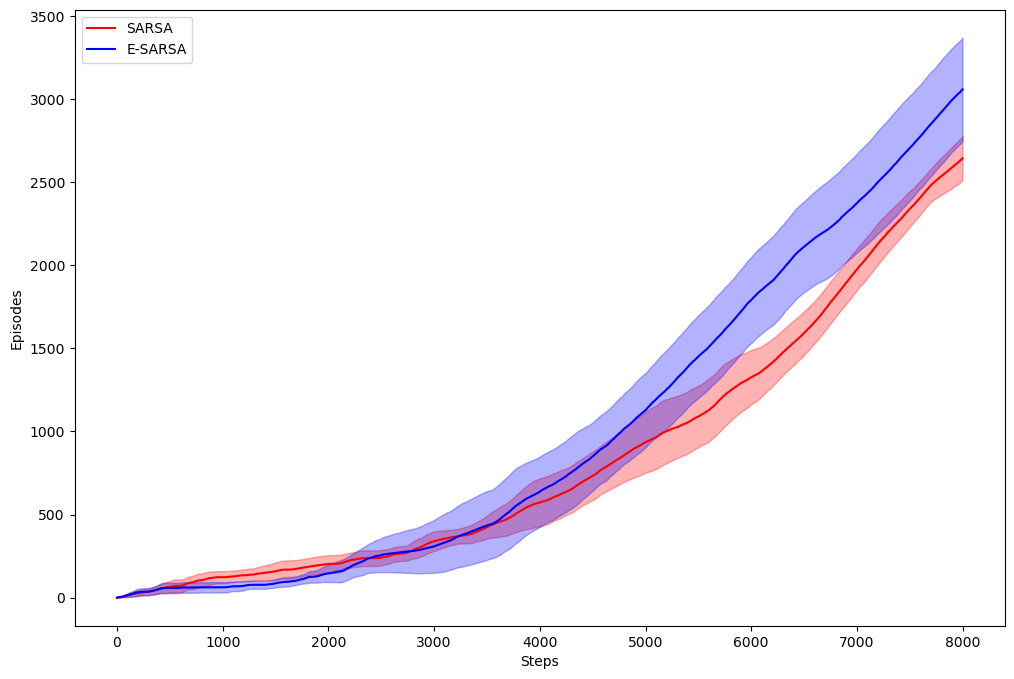

In [11]:

if __name__ == "__main__":
    # set randomness
    np.random.seed(1234)
    random.seed(1234)

    # trial number
    trial_num = 10

    # maximal time steps
    # max_time_steps = 8000
    max_time_steps = 8000

    # run SARSA and Q Learning
    run_on_policy_td_control(trial_num, max_time_steps)

#### SARSA_alpha_var

In [ ]:
def runSARSA_alpha_var(env, run_num, timeout):

    # parameters
    epsilon = 0.1
    alpha = 0.5
    gamma = 0.9
    lam = 0.3

    # create the expected SARSA
    results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = SARSA(env, alpha, epsilon, gamma, timeout)
        episodes, sarsa_t = controller.run()
        # append the results
        results_list.append(episodes[0:timeout])

    Q_array = np.array(results_list)
    
    alpha = 0.1
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_SARSA(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_01 = np.array(E_results_list)

    alpha = 0.3
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_SARSA(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_03 = np.array(E_results_list)

    alpha = 0.5
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_SARSA(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_05 = np.array(E_results_list)

    alpha = 0.7
    # create the expected SARSA
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_SARSA(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_07 = np.array(E_results_list)

    alpha = 0.9
    # create the expected SARSA
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_SARSA(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_09 = np.array(E_results_list)

    # Plot the results
    plot_curves(
        [Q_array, E_array_01, E_array_03, E_array_05, E_array_07, E_array_09],
        ['SARSA-0.5', 'E-SARSA-0.1', 'E-SARSA-0.3', 'E-SARSA-0.5', 'E-SARSA-0.7', 'E-SARSA-0.9'],
        ['r', 'b', 'g', 'black', 'purple', 'cyan', 'yellow', 'violet'],
        "Episodes"
    )

#### Q_alpha_var

In [23]:
def runQ_alpha_var(env, run_num, timeout):

    # parameters
    epsilon = 0.1
    alpha = 0.5
    gamma = 0.9
    lam = 0.3

    # create the expected SARSA
    results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = QLearning(env, alpha, epsilon, gamma, timeout)
        episodes, sarsa_t = controller.run()
        # append the results
        results_list.append(episodes[0:timeout])

    Q_array = np.array(results_list)
    
    alpha = 0.1
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_QLearning(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_01 = np.array(E_results_list)

    alpha = 0.3
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_QLearning(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_03 = np.array(E_results_list)

    alpha = 0.5
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_QLearning(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_05 = np.array(E_results_list)

    alpha = 0.7
    # create the expected SARSA
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_QLearning(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_07 = np.array(E_results_list)

    alpha = 0.9
    # create the expected SARSA
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_QLearning(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_09 = np.array(E_results_list)

    # Plot the results
    plot_curves(
        [Q_array, E_array_01, E_array_03, E_array_05, E_array_07, E_array_09],
        ['QLearning-0.5', 'E-QLearning-0.1', 'E-QLearning-0.3', 'E-QLearning-0.5', 'E-QLearning-0.7', 'E-QLearning-0.9'],
        ['r', 'b', 'g', 'black', 'purple', 'cyan', 'yellow', 'violet'],
        "Episodes"
    )

#### Expected_SARSA_alpha_var 

In [25]:
def runExpected_SARSA_alpha_var(env, run_num, timeout):

    # parameters
    epsilon = 0.1
    alpha = 0.5
    gamma = 0.9
    lam = 0.3

    # create the expected SARSA
    results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = Expected_SARSA(env, alpha, epsilon, gamma, timeout)
        episodes, sarsa_t = controller.run()
        # append the results
        results_list.append(episodes[0:timeout])

    Q_array = np.array(results_list)
    
    alpha = 0.1
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_Expected_SARSA(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_01 = np.array(E_results_list)

    alpha = 0.3
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_Expected_SARSA(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_03 = np.array(E_results_list)

    alpha = 0.5
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_Expected_SARSA(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_05 = np.array(E_results_list)

    alpha = 0.7
    # create the expected SARSA
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_Expected_SARSA(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_07 = np.array(E_results_list)

    alpha = 0.9
    # create the expected SARSA
    E_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller = E_Expected_SARSA(env, alpha, epsilon, gamma, lam, timeout)
        episodes, e_sarsa_t = controller.run()
        # append the results
        E_results_list.append(episodes[0:timeout])

    E_array_09 = np.array(E_results_list)

    # Plot the results
    plot_curves(
        [Q_array, E_array_01, E_array_03, E_array_05, E_array_07, E_array_09],
        ['Expected SARSA-0.5', 'E-Expected SARSA-0.1', 'E-Expected SARSA-0.3', 'E-Expected SARSA-0.5', 'E-Expected SARSA-0.7', 'E-Expected SARSA-0.9'],
        ['r', 'b', 'g', 'black', 'purple', 'cyan', 'yellow', 'violet'],
        "Episodes"
    )

### Plot

<Figure size 640x480 with 0 Axes>

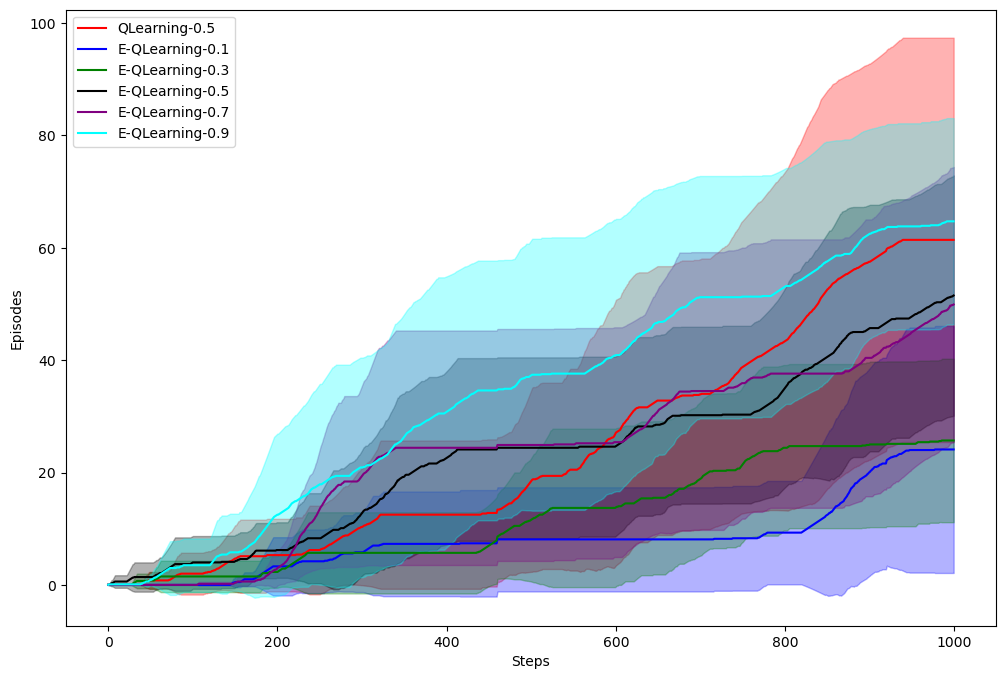

<Figure size 640x480 with 0 Axes>

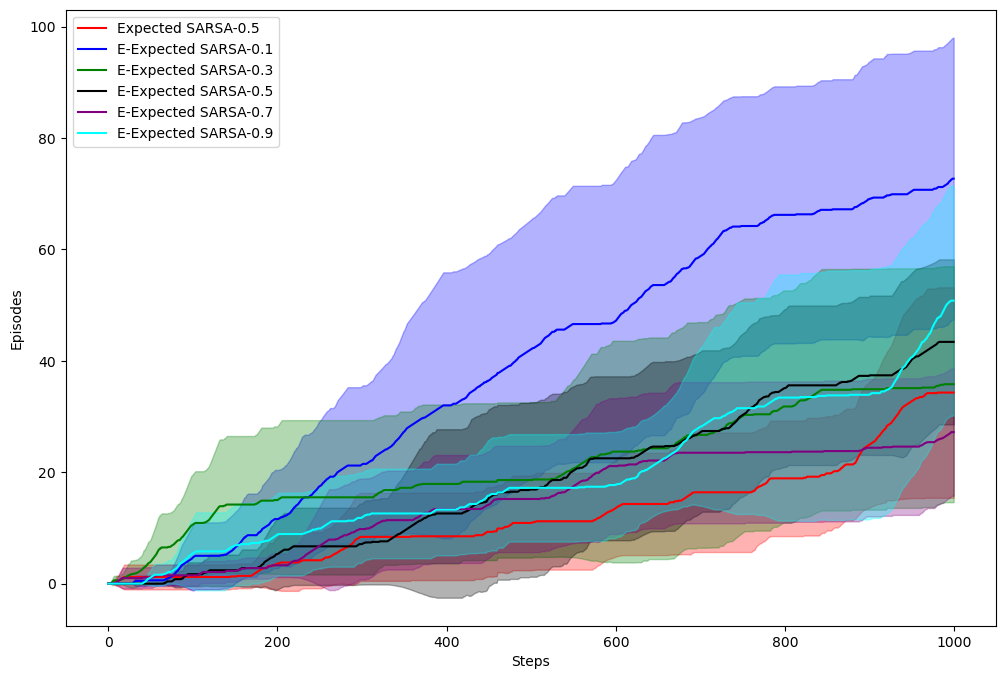

In [26]:

if __name__ == "__main__":
    # set randomness
    np.random.seed(1234)
    random.seed(1234)

    # trial number
    trial_num = 10

    # maximal time steps
    # max_time_steps = 8000
    max_time_steps = 1000

    env = FourRooms()
    # env = WindyGridWorld()

    # run SARSA and Q Learning
    runQ_alpha_var(env, trial_num, max_time_steps)
    runExpected_SARSA_alpha_var(env, trial_num, max_time_steps)